# Phishing Email Detection

### Import all the libraries

In [1]:
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Unprocessed dataset

In [2]:
file_names = [
    'CEAS_08.csv', 'Enron.csv', 'Ling.csv', 'Nazario.csv',
    'Nigerian_Fraud.csv', 'SpamAssassin.csv'
]
columns_to_keep = ['subject', 'body', 'label']
dataframes = []

# Load each CSV, keep only the necessary columns, and handle missing columns
for file_name in file_names:
    try:
        # Load dataset
        df_temp = pd.read_csv(file_name)

        # Handle phishing_email.csv-specific column renaming
        if "text_combined" in df_temp.columns:
            df_temp.rename(columns={"text_combined": "body"}, inplace=True)

        # Keep only relevant columns, filling missing ones with appropriate placeholders
        df_temp = df_temp.reindex(columns=columns_to_keep, fill_value="No Subject")

        # Append to the list of dataframes
        dataframes.append(df_temp)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")

# Concatenate all dataframes into 'raw_df'
raw_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the resulting dataset
print("Dataset Preview:")
print(raw_df.head())

File SpamAssassin.csv not found. Skipping.
Dataset Preview:
                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  label  
0  Buck up, your troubles caused by small dimensi...      1  
1  \nUpgrade your sex and pleasures with these te...      1  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1  
3  Would anyone object to removing .so from this ...      0  
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...      1  


In [3]:
print("Summary of the final dataframe (raw_df):")
print(raw_df.info())

print("\nFirst few rows of the dataframe:")
print(raw_df.head())

# Check for missing values
print("\nMissing values per column:")
print(raw_df.isnull().sum())

# Check the distribution of the labels
print("\nLabel distribution:")
print(raw_df['label'].value_counts())

Summary of the final dataframe (raw_df):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76677 entries, 0 to 76676
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  76346 non-null  object
 1   body     76677 non-null  object
 2   label    76677 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB
None

First few rows of the dataframe:
                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  label  
0  Buck up, your troubles caused by small dimensi...      1  
1  \nUpgrade your sex and pleasures with these te...      1  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...  

In [4]:
# Fill missing values in 'subject' and 'body' columns with empty strings
raw_df['subject'] = raw_df['subject'].fillna("")
raw_df['body'] = raw_df['body'].fillna("")

# Calculate the length of subject and body columns
raw_df['subject_length'] = raw_df['subject'].apply(len)
raw_df['body_length'] = raw_df['body'].apply(len)

# Identify thresholds for outliers using the 99th percentile
subject_length_threshold = raw_df['subject_length'].quantile(0.99)
body_length_threshold = raw_df['body_length'].quantile(0.99)

print(f"Subject Length Threshold (99th Percentile): {subject_length_threshold}")
print(f"Body Length Threshold (99th Percentile): {body_length_threshold}")

# Filter rows where lengths exceed the thresholds
subject_outliers = raw_df[raw_df['subject_length'] > subject_length_threshold]
body_outliers = raw_df[raw_df['body_length'] > body_length_threshold]

# Display the number of outliers and some examples
print("\nSubject Outliers:")
print(f"Count: {len(subject_outliers)}")
print(subject_outliers[['subject', 'subject_length']].head())

print("\nBody Outliers:")
print(f"Count: {len(body_outliers)}")
print(body_outliers[['body', 'body_length']].head())

Subject Length Threshold (99th Percentile): 101.0
Body Length Threshold (99th Percentile): 11931.680000000037

Subject Outliers:
Count: 735
                                               subject  subject_length
3    Re: svn commit: r619753 - in /spamassassin/tru...             150
57   [Perl Jobs] Perl & Apache & Unix/Linux & Mysql...             114
122  Re: svn commit: r619753 - in /spamassassin/tru...             150
155  Join the only real club! The winner's club! Wi...             183
159  For: 90e5bd77f1c295c6230bf2386176ab32 Stock Ma...             116

Body Outliers:
Count: 767
                                                  body  body_length
3    Would anyone object to removing .so from this ...        24418
19   Steve Jacobs wrote: > ---------- Forwarded mes...        13442
56   Hello Andrew,\n\nORGANIC BYTES #140\nHealth, J...        12338
101  Send Wekalist mailing list submissions to \tiu...        13142
136  \n\n\nScience Online Editors' Choice Alert: 31...        12112

### Load the cleaned dataset and analyse

In [5]:
# Load the dataset
df = pd.read_csv('phishing_email.csv')

# Display the first few rows of the dataset
print(df.head())

# Check the distribution of labels
print('--------------\nLabels:')
print(df['label'].value_counts())

# Check for missing values
print('--------------\nNull Values:')
print(df.isnull().sum())

df = df.dropna(subset=['label'])



                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0
--------------
Labels:
label
1    42891
0    39595
Name: count, dtype: int64
--------------
Null Values:
text_combined    0
label            0
dtype: int64


### EDA

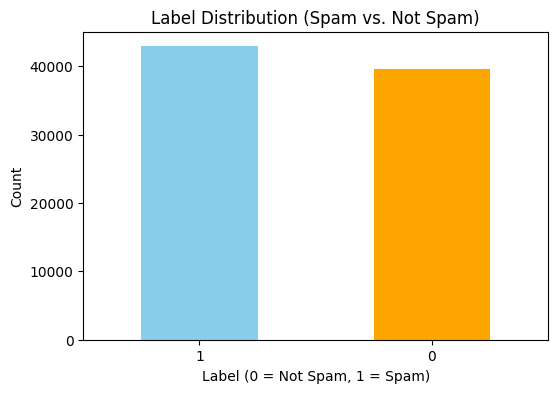

In [6]:
import matplotlib.pyplot as plt

# Label distribution
label_distribution = df['label'].value_counts()

# Visualizing label distribution
plt.figure(figsize=(6, 4))
label_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution (Spam vs. Not Spam)')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
text_combined    0
label            0
dtype: int64


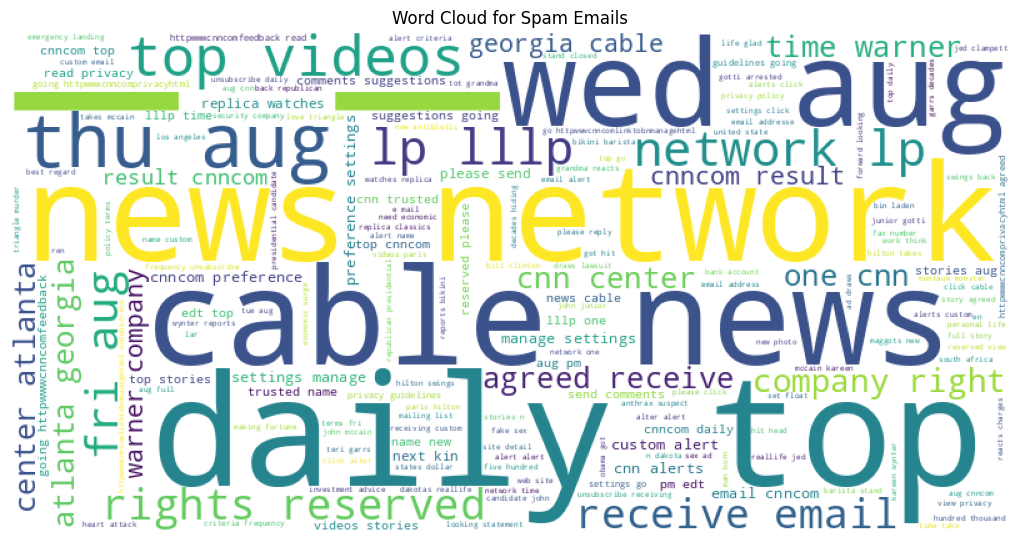

In [8]:
from wordcloud import WordCloud

# Word Cloud for Spam Emails
spam_words = ' '.join(list(df[df['label'] == 1]['text_combined']))
spam_wc = WordCloud(width = 800, height = 400, background_color='white').generate(spam_words)
plt.figure(figsize = (10, 7), facecolor = None)
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title('Word Cloud for Spam Emails')
plt.show()

The word cloud contains frequent terms that seem to closely mimic legitimate news or media content. Words like "top," "news," "daily," and brand names like "CNN" and "Warner" suggest the emails are curated to appear trustworthy. Noticing the specific days of the week and months like "Wed," "Thu," and "Aug" featured prominently could indicate attempts to tie the spam to current events or timely offers, enhancing their seeming relevance. There are abbreviations and words with typos as well including in this set.

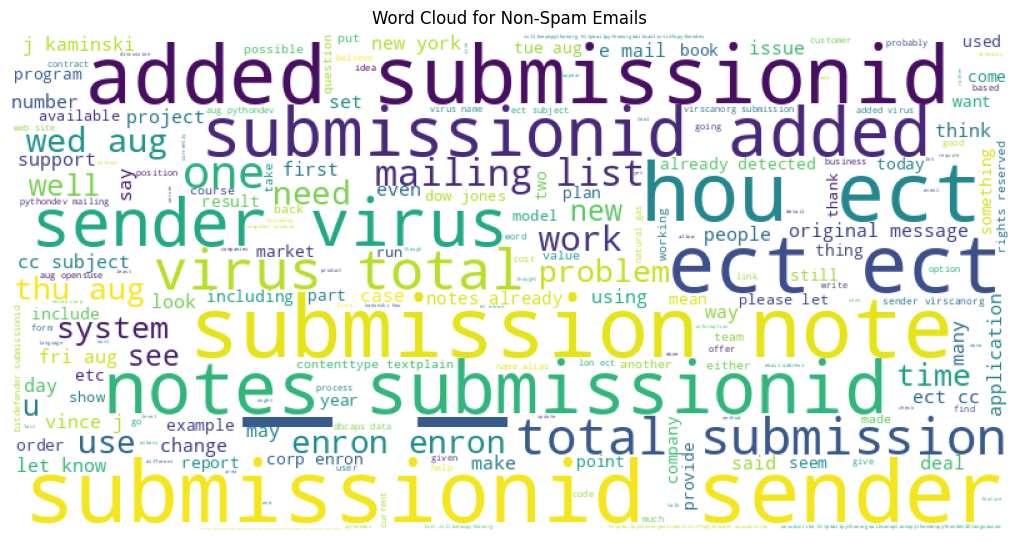

In [9]:
#Word Cloud for Non-Spam Emails
non_spam_words = ' '.join(list(df[df['label'] == 0]['text_combined']))
non_spam_wc = WordCloud(width = 800, height = 400, background_color='white').generate(non_spam_words)
plt.figure(figsize = (10, 7), facecolor = None)
plt.imshow(non_spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title('Word Cloud for Non-Spam Emails')
plt.show()

We see professional terms like "submission," "project," and "system," which are likely part of regular business communications. This contrast with spam emails could be key in distinguishing between the two. The presence of specific days and months (e.g., "Tue," "Aug") can be further explored to understand if there's a pattern in the timing of legitimate emails versus spam.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3000)

# Transform the text data of spam emails only
E = vectorizer.fit_transform(df[df['label'] == 1]['text_combined'])

# Sum up the counts of each vocabulary word
sum_words = E.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Convert to DataFrame
word_freq = pd.DataFrame(words_freq, columns=['word', 'frequency'])

# Sort by frequency and display the top 20
top_words = word_freq.sort_values(by='frequency', ascending=False).head(20)
print("\nTop 20 most common words in spam emails:")
print(top_words)


Top 20 most common words in spam emails:
             word  frequency
2806         2008      32008
469            10      29428
1143          aug      28037
98          email      26289
495       company      18244
185         money      17829
645       account      16337
703          news      15935
2841       cnncom      14533
347          time      14143
103   information      12929
1487        daily      12242
1838          cnn      11711
534      business      11656
308           new      11498
17            com      10701
644          bank      10552
140         click      10467
89        receive      10188
42           free       9605


### Conclusions from EDA

1. Words like "click," "receive," "free," and "offer" suggest that spam emails often contain calls to action, offering incentives or prompting recipients to take immediate actions, which is typical for spam aiming to get quick responses from the recipients.
2. Terms such as "company," "account," "bank," and "money" indicate that many spam emails involve commercial content, potentially scams related to financial transactions.
4. The word "cnncom" (probably a misspelling or manipulation of 'cnn.com') and "news" suggest attempts to mimic legitimate news sources or include news-related content, potentially to increase the credibility of the spam or engage users by leveraging familiar names.
5. "Your" appears in the list, indicating a direct address to the recipient, making the email appear more personalized, which is a common tactic in phishing emails to gain trust.

### Text Vectorization

In [11]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=3000)

# Transform the text data
X = vectorizer.fit_transform(df['text_combined']).toarray()
y = df['label']

### Split data to train and test datasets

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### First Model - Logistic Regression

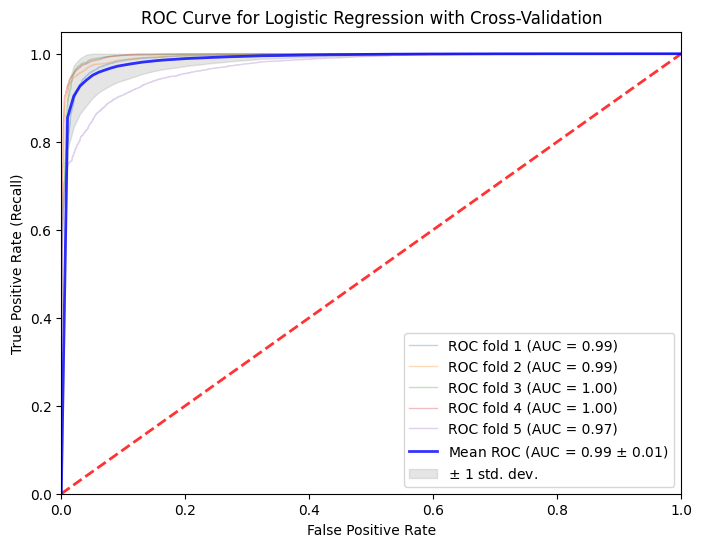

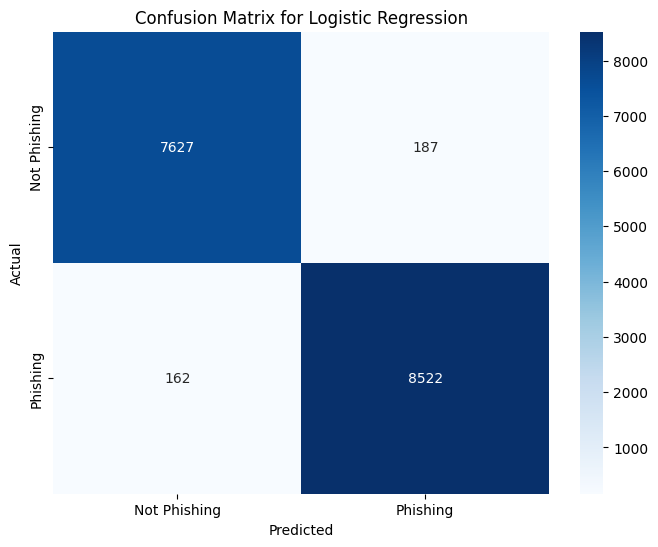

Accuracy: 0.9788459207176627
Precision: 0.9785279595820415
Recall: 0.9813450023030862
F1-Score: 0.9799344563905019


In [13]:
# Define the model
logreg = LogisticRegression()
logreg_cv = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = logreg_cv.fit(X[train], y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Logistic Regression with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')



### Second Model - Random Forest

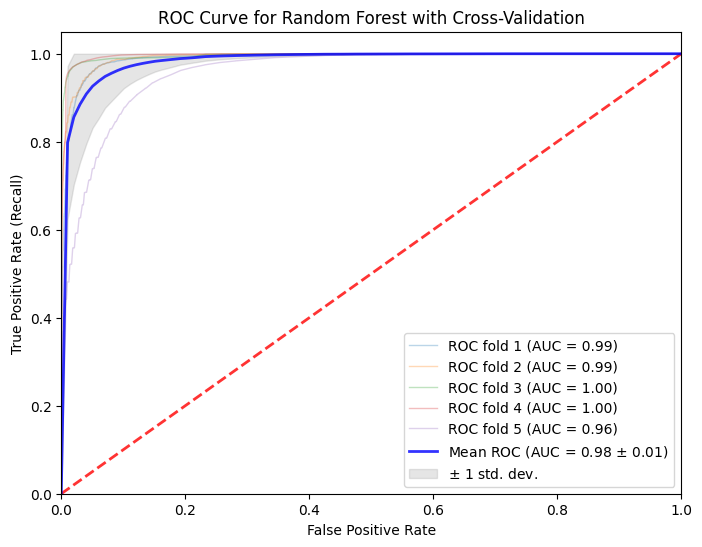

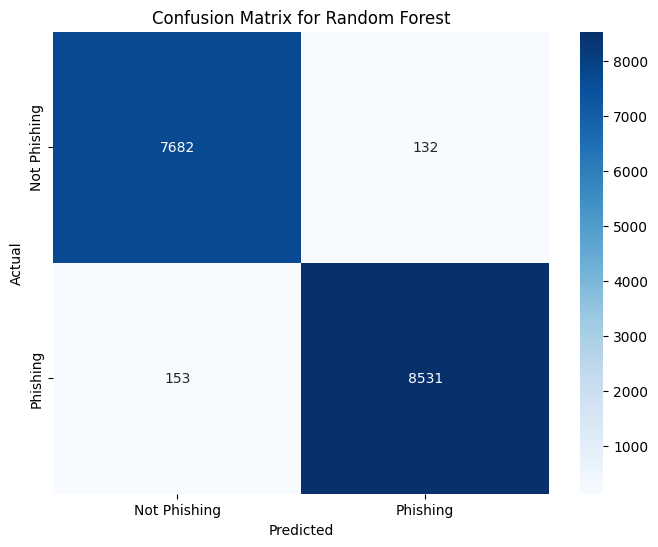

Accuracy: 0.9827251788095527
Precision: 0.9847627842548771
Recall: 0.9823813910640258
F1-Score: 0.9835706462212487


In [14]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model_cv = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

tprs_rf = []
aucs_rf = []
mean_fpr_rf = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

# Perform cross-validation and plot the ROC curve for each fold
for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = rf_model_cv.fit(X[train], y[train]).predict_proba(X[test])
    fpr_rf, tpr_rf, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs_rf.append(np.interp(mean_fpr_rf, fpr_rf, tpr_rf))
    tprs_rf[-1][0] = 0.0
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs_rf.append(roc_auc_rf)
    plt.plot(fpr_rf, tpr_rf, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rf, std_auc_rf), lw=2, alpha=0.8)

std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
plt.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Random Forest with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

# Evaluate the model trained with complete dataset
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1-Score: {f1_rf}')


### Naive Bayes

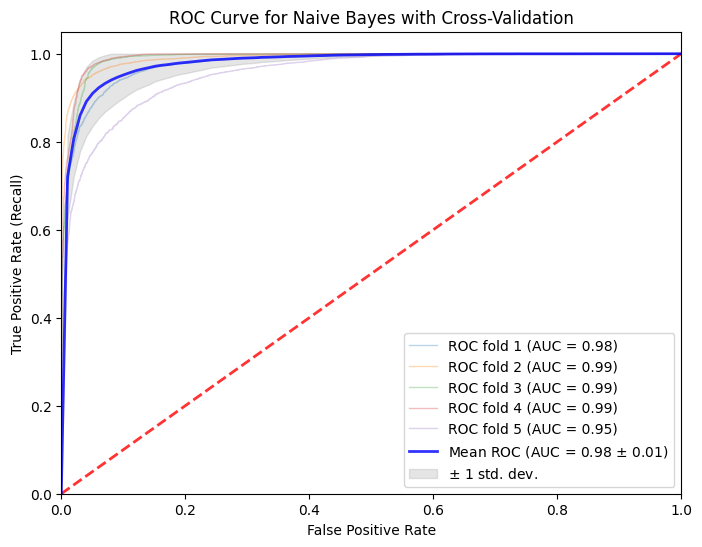

Naive Bayes Accuracy: 0.953388289489635
Naive Bayes Precision: 0.9761761520875948
Naive Bayes Recall: 0.9342468908337171
Naive Bayes F1-Score: 0.954751397469844


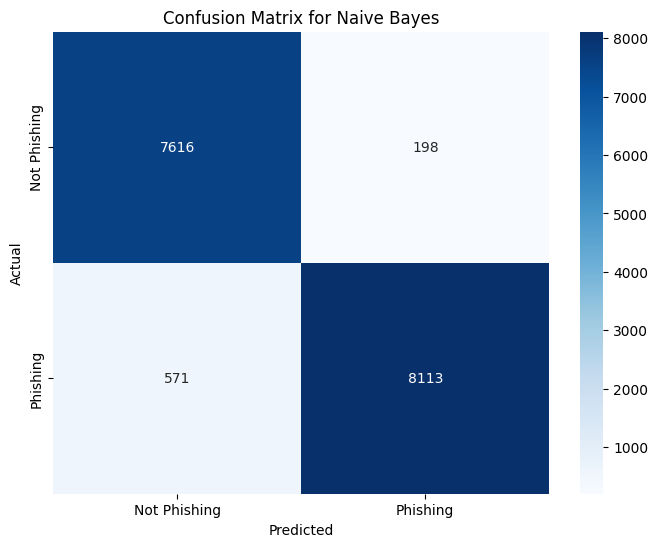

In [15]:
# Create the Naive Bayes model
nb_model = MultinomialNB()
nb_model_cv = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]

tprs_nb = []
aucs_nb = []
mean_fpr_nb = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(X, y)):
    probas_ = nb_model_cv.fit(X[train], y[train]).predict_proba(X[test])
    fpr_nb, tpr_nb, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs_nb.append(np.interp(mean_fpr_nb, fpr_nb, tpr_nb))
    tprs_nb[-1][0] = 0.0
    roc_auc_nb = auc(fpr_nb, tpr_nb)
    aucs_nb.append(roc_auc_nb)
    plt.plot(fpr_nb, tpr_nb, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_nb[-1] = 1.0
mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
std_auc_nb = np.std(aucs_nb)
plt.plot(mean_fpr_nb, mean_tpr_nb, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb), lw=2, alpha=0.8)

std_tpr_nb = np.std(tprs_nb, axis=0)
tprs_upper_nb = np.minimum(mean_tpr_nb + std_tpr_nb, 1)
tprs_lower_nb = np.maximum(mean_tpr_nb - std_tpr_nb, 0)
plt.fill_between(mean_fpr_nb, tprs_lower_nb, tprs_upper_nb, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Naive Bayes with Cross-Validation')
plt.legend(loc="lower right")
plt.show()

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f'Naive Bayes Accuracy: {accuracy_nb}')
print(f'Naive Bayes Precision: {precision_nb}')
print(f'Naive Bayes Recall: {recall_nb}')
print(f'Naive Bayes F1-Score: {f1_nb}')

# Compute the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()


### Phishing Detection Application

In [16]:
def predict_phishing(email_body, model, vectorizer):
    """
    Predicts whether an email is a phishing email.

    Parameters:
    email_body (str): The body of the email to classify.
    model: The trained machine learning model.
    vectorizer: The vectorizer used to transform the text data.

    Returns:
    str: 'Phishing' if the email is a phishing email, otherwise 'Not Phishing'.
    """

    # Preprocess the email body (assuming similar preprocessing used during training)
    def preprocess_text(text):
        text = re.sub('[^a-zA-Z\s]', '', text)
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text

    # Preprocess the email body
    processed_email = preprocess_text(email_body)

    # Transform the email body using the trained vectorizer
    email_vector = vectorizer.transform([processed_email])

    # Predict the label using the model
    prediction = model.predict(email_vector)

    # Return the result
    return 'Phishing' if prediction[0] == 1 else 'Not Phishing'


In [17]:
email_phishing = "Dear Customer, Your account has been compromised. Please click the link below to verify your identity and secure your account: https://www.clickme.com"
email_non_phishing = "Hello Team, Please find attached the meeting minutes from yesterday's discussion. Looking forward to your feedback."

# Models
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf_model,
    "Naive Bayes": nb_model
}

# Predict results
results = []

for model_name, model in models.items():
    result_phishing = predict_phishing(email_phishing, model, vectorizer)
    result_non_phishing = predict_phishing(email_non_phishing, model, vectorizer)
    results.append([model_name, result_phishing, result_non_phishing])

# Display results in a table
import pandas as pd

results_df = pd.DataFrame(results, columns=["Model", "Phishing Email Result", "Non-Phishing Email Result"])
print(results_df.to_markdown(index=False))


| Model               | Phishing Email Result   | Non-Phishing Email Result   |
|:--------------------|:------------------------|:----------------------------|
| Logistic Regression | Phishing                | Not Phishing                |
| Random Forest       | Phishing                | Not Phishing                |
| Naive Bayes         | Phishing                | Not Phishing                |
